*   FanGraphsから打者データを抽出（2025, 選手ごと）
*   RARにおける各構成要素の寄与度を探る

### Fangraphs

# ライブラリのインポート

In [55]:
# ライブラリ群のインポート
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from urllib.parse import urlencode, urlparse, parse_qs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 定数および補正データの定義

In [28]:
# 総得点・イニング数（RPW算出に使用、元データに誤りがあるため辞書形式で固定。イニング数はアウトカウントとする。）
rpw_material = {2025: [5654, 46177]}

# 補正対象選手（野手）
player_adj = {2025: ['16219', 'sa3063615', 'sa3062961']}

# 関数の定義

In [56]:
# 関数1. FanGraphsリーダーボードから情報を取得（2025年度のみ）

def fetch_npb_lb_2025(
    stats_type: str,
    qual: int = 0,
    type_: int = 0
) -> pd.DataFrame:

    start_year = 2025
    end_year = 2025

    all_records = []

    # チームのクエリ順
    teams = [4, 6, 7, 8, 9, 13,  3, 5, 10, 11, 12, 14]
    # セントラルリーグのチーム
    cl_teams = {4, 6, 7, 8, 9, 13}
    # パシフィックリーグのチーム
    pl_teams = {3, 5, 10, 11, 12, 14}

    base_url = 'https://www.fangraphs.com/leaders/international/npb'

    for season in range(start_year, end_year + 1):
        for team in teams:
            # リクエストURLを構築
            params = {
                'qual': qual,
                'seasonstart': season,
                'seasonend':   season,
                'stats':       stats_type,
                'team':        team
            }
            url = base_url + '?' + urlencode(params)

            # ページをフェッチして解析
            res = requests.get(url)
            res.raise_for_status()
            soup = BeautifulSoup(res.text, 'html.parser')

            # 埋め込みJSONデータを抽出
            script = soup.find('script', id='__NEXT_DATA__')
            data = json.loads(script.string)
            queries = data['props']['pageProps']['dehydratedState']['queries']

            # レコードリストを特定
            records = None
            for q in queries:
                dl = q.get('state', {}).get('data')
                if isinstance(dl, list) and dl and 'Name' in dl[0]:
                    records = dl
                    break

            if records is None:
                raise RuntimeError(f"シーズン={season}, チーム={team} のデータがありません")

            # 各レコードにシーズンとリーグをアノテーション
            for rec in records:
                rec['Season'] = season
                if team in cl_teams:
                    rec['League'] = 'cl'
                elif team in pl_teams:
                    rec['League'] = 'pl'
                else:
                    rec['League'] = None

                # 'Name'フィールドのURLからPositionパラメータを抽出
                name_html = rec.get('Name') or ''
                tag_soup = BeautifulSoup(name_html, 'html.parser')
                a = tag_soup.find('a')
                if a and a.has_attr('href'):
                    qs = urlparse(a['href']).query
                    params2 = parse_qs(qs)
                    rec['Position'] = params2.get('position', [None])[0]
                else:
                    rec['Position'] = None

            all_records.extend(records)

    # レコードのリストをDataFrameに正規化
    df = pd.json_normalize(all_records)
    # 'PA'が0の行をフィルタリング
    df = df[df['PA'] > 0].copy()

    # 要求に応じて'Name'フィールドを削除
    df = df.drop(columns=['Name'])

    return df

In [46]:
# 関数2. 値が2倍カウントされているレコードの補正

def adjust_player_stats(
    df: pd.DataFrame,
    player_adjustments: dict # 補正対象のプレイヤーIDを年度ごとの辞書として受け取る
) -> pd.DataFrame:
    """
    データフレームと補正対象のプレイヤーIDリスト（年度ごとに辞書形式）を引数に取り、
    指定されたカラムの値を半分にする関数。

    Args:
        df (pd.DataFrame): 補正対象のデータフレーム。
        player_adjustments (dict): キーが年度、値がその年度の補正対象プレイヤーIDのリストである辞書。

    Returns:
        pd.DataFrame: 補正が適用されたデータフレーム。
    """
    # 1. 入力データフレームのコピーを作成
    df_adjusted = df.copy()

    # 2. playerids_str列を追加し、既存のplayerids列の値を文字列型に変換
    df_adjusted['playerids_str'] = df_adjusted['playerids'].astype(str)

    # 3. 値を半分にするカラムを定義
    columns_to_half = [
        'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI',
        'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'wRAA', 'wRC'
    ]

    # 4. 補正対象のシーズンとplayeridsを持つプレイヤーを特定し、補正を適用
    # player_adjustments辞書をループして、年度ごとに補正を適用する
    for season, player_ids_list in player_adjustments.items():
        mask = (df_adjusted['Season'] == season) & (df_adjusted['playerids_str'].isin(player_ids_list))

        # 特定されたプレイヤーに対して、指定されたカラムの値を半分にする
        for col in columns_to_half:
            # colがdf_adjustedに存在し、数値型の場合のみ処理を行う
            if col in df_adjusted.columns and pd.api.types.is_numeric_dtype(df_adjusted[col]):
                df_adjusted.loc[mask, col] = df_adjusted.loc[mask, col] / 2

    # 5. 作業用の 'playerids_str' 列は削除する
    df_adjusted = df_adjusted.drop(columns=['playerids_str'])

    return df_adjusted

In [45]:
# 関数3. 各種係数の算出

def compute_coef_by_season(
    df: pd.DataFrame,
    lower_q: float = 0.025,
    upper_q: float = 0.975
) -> pd.DataFrame:
    """
    df に Season, League, Position, R, PA, wRC 列を持つ前提で、
    各シーズンごとに下記を計算し、列としてまとめた DataFrame を返す。

    - uBB, HBP, 1B, 2B, 3B, HR の回帰係数
    - league_wOBA
    - wOBAscale（PA*wOBAとの差から算出し、上下トリム後に平均）
    - lgR_PA : R合計 / PA合計
    - PA_cl_nonP, PA_pl_nonP : cl/pl かつ Position!=\"P\" の PA合計
    - wRC_cl_nonP, wRC_pl_nonP : cl/pl かつ Position!=\"P\" の wRC合計
    - RPW: 総得点とイニング数から計算されるRPW (rpw_materialを参照)
    """
    results = []

    for season, df_sea in df.groupby('Season'):
        # --- RPW計算 --- (rpw_materialはグローバルに定義されていると仮定)
        rpw_calculated = np.nan
        if season in rpw_material:
            values = rpw_material.get(season)
            if values and len(values) == 2:
                first_value = values[0]
                second_value = values[1]
                if second_value != 0: # 0除算を避ける
                    rpw_calculated = (first_value / second_value) * 27 * 1.5 + 3

        # --- 基本フィルタ＆uBB計算 ---
        df_sea = df_sea[df_sea['PA'] > 0].copy()
        df_sea['uBB'] = df_sea['BB'] - df_sea['IBB']

        # --- wOBA回帰用の y ---
        df_sea['denom'] = (
            df_sea['AB']
            + df_sea['BB']
            - df_sea['IBB']
            + df_sea['SF']
            + df_sea['HBP']
        )
        df_sea['y'] = df_sea['denom'] * df_sea['wOBA']

        # --- 回帰計算 ---
        X = df_sea[['uBB','HBP','1B','2B','3B','HR']].values
        y = df_sea['y'].values
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)

        # --- league_wOBA計算 ---
        tot_H   = df_sea['H'].sum()
        tot_uBB = df_sea['uBB'].sum()
        tot_HBP = df_sea['HBP'].sum()
        tot_SF  = df_sea['SF'].sum()
        tot_AB  = df_sea['AB'].sum()
        league_wOBA = (tot_H + tot_uBB + tot_HBP) / (tot_AB + tot_uBB + tot_HBP + tot_SF)

        # --- wOBAscale計算 ---
        df_sea['scale'] = ((df_sea['wOBA'] - league_wOBA) * df_sea['PA']) / df_sea['wRAA']
        scales = df_sea['scale'].replace([np.inf, -np.inf], np.nan).dropna()
        lo, hi = scales.quantile([lower_q, upper_q])
        mean_scale = scales[(scales >= lo) & (scales <= hi)].mean()

        # --- 追加指標の計算 ---
        total_R   = df_sea['R'].sum()
        total_PA  = df_sea['PA'].sum()
        lgR_PA    = total_R / total_PA if total_PA > 0 else np.nan

        # clリーグ・非投手
        mask_cl = (df_sea['League'] == 'cl') & (df_sea['Position'] != 'P')
        PA_cl_nonP   = df_sea.loc[mask_cl, 'PA'].sum()
        wRC_cl_nonP = df_sea.loc[mask_cl, 'wRC'].sum()
        wRC_PA_cl = wRC_cl_nonP / PA_cl_nonP if PA_cl_nonP > 0 else np.nan

        # plリーグ・非投手
        mask_pl = (df_sea['League'] == 'pl') & (df_sea['Position'] != 'P')
        PA_pl_nonP   = df_sea.loc[mask_pl, 'PA'].sum()
        wRC_pl_nonP = df_sea.loc[mask_pl, 'wRC'].sum()
        wRC_PA_pl = wRC_pl_nonP / PA_pl_nonP if PA_pl_nonP > 0 else np.nan

        # --- 辞書にまとめてリストに追加 ---
        results.append({
            'Season':        season,
            'uBB':           beta[0],
            'HBP':           beta[1],
            '1B':            beta[2],
            '2B':            beta[3],
            '3B':            beta[4],
            'HR':            beta[5],
            'lg_wOBA':   league_wOBA,
            'wOBAscale':     mean_scale,
            'lgR_PA':        lgR_PA,
            'PA_cl_nonP':    PA_cl_nonP,
            'PA_pl_nonP':    PA_pl_nonP,
            'wRC_cl_nonP':   wRC_cl_nonP,
            'wRC_pl_nonP':   wRC_pl_nonP,
            'wRC_PA_cl':     wRC_PA_cl,
            'wRC_PA_pl':     wRC_PA_pl,
            'RPW':           rpw_calculated # RPWを追加
        })

    return pd.DataFrame(results).sort_values('Season').reset_index(drop=True)

In [57]:
def calculate_pf(
    list_df: pd.DataFrame,
    coef_df: pd.DataFrame
) -> pd.DataFrame:
    """
    選手データとシーズン係数データを受け取り、PF (Park Factor) を計算する関数。

    Args:
        list_df (pd.DataFrame): 選手ごとの打撃統計を含むデータフレーム。
                                'Season', 'League', 'Team', 'wRC+', 'wRAA', 'PA' などの列が必要。
        coef_df (pd.DataFrame): シーズンごとのリーグ係数を含むデータフレーム。
                                'Season', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl' などの列が必要。

    Returns:
        pd.DataFrame: シーズン、リーグ、チームごとのPFを含むデータフレーム。
    """

    # 1. list_dfとcoef_dfをSeasonで結合
    df_all = pd.merge(list_df, coef_df[['Season', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl']], on='Season', how='left')

    # 2. リーグに応じてwRC_PAを選択
    df_all['wRC_PA'] = np.where(df_all['League'] == 'cl', df_all['wRC_PA_cl'], df_all['wRC_PA_pl'])
    df_all.drop(columns=['wRC_PA_cl', 'wRC_PA_pl'], inplace=True)

    # 3. 各レコードのPFを計算
    df_all['PF'] = np.where(
        df_all['wRC+'].isna() |
        (df_all['wRC+'] == -100) |
        (df_all['PA'] == 0),
        np.nan,
        2 - (((df_all['wRC+'] / 100) * df_all['wRC_PA'] - (df_all['wRAA'] / df_all['PA'])) / df_all['lgR_PA']))

    # 4. Team, League, SeasonごとのPA重み付き平均PFを計算
    df_valid = df_all[df_all['PF'].notna()].copy()
    df_valid['PFxPA'] = df_valid['PF'] * df_valid['PA']
    df_out = (
        df_valid
        .groupby(['Season', 'League', 'Team'])
        .agg(
            total_PFxPA=('PFxPA', 'sum'),
            total_PA=('PA', 'sum')
        )
        .reset_index()
    )
    df_out['PF'] = df_out['total_PFxPA'] / df_out['total_PA']

    return (
        df_out[['Season', 'League', 'Team', 'PF']]
        .sort_values(['Season','League','Team'])
        .reset_index(drop=True)
    )

In [39]:
# 関数5. 各選手レコードへのPF適用

def attach_pf(
    list_df: pd.DataFrame,
    coef_df: pd.DataFrame,
    pf_df: pd.DataFrame
) -> pd.DataFrame:
    """
    選手データフレームにPark Factor (PF) を追加する関数。

    Args:
        list_df (pd.DataFrame): 選手ごとの打撃統計を含むデータフレーム。
                                ('Season', 'League', 'Team', 'wRC+', 'wRAA', 'PA'などが含まれる)
        coef_df (pd.DataFrame): シーズンごとのリーグ係数を含むデータフレーム。
                                ('Season', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl'などが含まれる)
        pf_df (pd.DataFrame): 各球団ごとの標準PFを含むデータフレーム。
                              ('Season', 'League', 'Team', 'PF'が含まれる)

    Returns:
        pd.DataFrame: 'PF'列が追加されたデータフレーム。
    """
    # 結合用の一時的なデータフレームを作成
    df_temp = list_df.copy()

    # 係数データフレームと結合
    df_temp = pd.merge(
        df_temp,
        coef_df[['Season', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl']],
        on='Season',
        how='left'
    )

    # 各球団PFデータフレームと結合（wRC+ = -100 のケースで参照するため）
    df_temp = pd.merge(
        df_temp,
        pf_df[['Season', 'League', 'Team', 'PF']].rename(columns={'PF': 'team_pf_value'}),
        on=['Season', 'League', 'Team'],
        how='left'
    )

    # NaN値を考慮して数値型に変換
    df_temp['wRC+'] = pd.to_numeric(df_temp['wRC+'], errors='coerce')
    df_temp['wRAA'] = pd.to_numeric(df_temp['wRAA'], errors='coerce')
    df_temp['PA'] = pd.to_numeric(df_temp['PA'], errors='coerce')
    df_temp['lgR_PA'] = pd.to_numeric(df_temp['lgR_PA'], errors='coerce')
    df_temp['wRC_PA_cl'] = pd.to_numeric(df_temp['wRC_PA_cl'], errors='coerce')
    df_temp['wRC_PA_pl'] = pd.to_numeric(df_temp['wRC_PA_pl'], errors='coerce')

    # 新しい 'PF' 列を初期化
    df_temp['PF'] = np.nan

    # --- ロジック適用 ---

    # 1. wRC+が-100の場合: team_pf_valueを適用
    mask_wrc_neg100 = (df_temp['wRC+'] == -100)
    df_temp.loc[mask_wrc_neg100, 'PF'] = df_temp.loc[mask_wrc_neg100, 'team_pf_value']

    # 計算に必要な全ての値が揃っているか確認するマスク
    # wRC+ != -100 のケースのみを対象とし、PA > 0 と lgR_PA がNaN/0でないことを確認
    mask_calc_base = (df_temp['wRC+'].notna()) & (df_temp['wRC+'] != -100) & \
                     (df_temp['PA'] > 0) & (df_temp['lgR_PA'].notna()) & (df_temp['lgR_PA'] != 0)

    # 共通の計算部分
    wrc_plus_ratio = df_temp['wRC+'] / 100
    wraa_per_pa = df_temp['wRAA'] / df_temp['PA']

    # 2. Leagueがclの場合
    mask_cl_calc = mask_calc_base & (df_temp['League'] == 'cl') & (df_temp['wRC_PA_cl'].notna())
    cl_numerator = (df_temp['wRC_PA_cl'] * wrc_plus_ratio - wraa_per_pa)
    df_temp.loc[mask_cl_calc, 'PF'] = 2 - (cl_numerator / df_temp['lgR_PA'])

    # 3. Leagueがplの場合
    mask_pl_calc = mask_calc_base & (df_temp['League'] == 'pl') & (df_temp['wRC_PA_pl'].notna())
    pl_numerator = (df_temp['wRC_PA_pl'] * wrc_plus_ratio - wraa_per_pa)
    df_temp.loc[mask_pl_calc, 'PF'] = 2 - (pl_numerator / df_temp['lgR_PA'])

    # 不要な一時列を削除
    df_temp = df_temp.drop(columns=['team_pf_value', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl'], errors='ignore')

    return df_temp

In [48]:
# 関数6. RAR, WARの算出と整形

def calculate_batrep(
    list_df: pd.DataFrame,
    coef_df: pd.DataFrame
) -> pd.DataFrame:
    """
    選手データフレームにRAR_bat, RAR_rep, RAR_batrep, WAR_batrepを追加する関数。

    Args:
        list_df (pd.DataFrame): 選手ごとの打撃統計を含むデータフレーム。
                                ('Season', 'League', 'wRAA', 'PA', 'PF'などが含まれる)
        coef_df (pd.DataFrame): シーズンごとのリーグ係数を含むデータフレーム。
                                ('Season', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl', 'RPW'などが含まれる)

    Returns:
        pd.DataFrame: 指定されたRARおよびWAR列が追加され、
                      特定の列に絞り込まれたデータフレーム。
    """
    df_temp = list_df.copy()

    # 係数データフレームと結合
    df_temp = pd.merge(
        df_temp,
        coef_df[['Season', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl', 'RPW']],
        on='Season',
        how='left'
    )

    # 必要な列を数値型に変換（エラーはNaNに）
    for col in ['wRAA', 'PA', 'PF', 'wRC+', 'lgR_PA', 'wRC_PA_cl', 'wRC_PA_pl', 'RPW']:
        df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')

    # RAR_bat の計算
    df_temp['RAR_bat'] = np.nan

    # Leagueがclの場合
    mask_cl = (df_temp['League'] == 'cl') & df_temp['wRC_PA_cl'].notna()
    df_temp.loc[mask_cl, 'RAR_bat'] = \
        df_temp.loc[mask_cl, 'wRAA'] + \
        ((2 - df_temp.loc[mask_cl, 'PF']) * df_temp.loc[mask_cl, 'lgR_PA'] - \
         df_temp.loc[mask_cl, 'wRC_PA_cl']) * df_temp.loc[mask_cl, 'PA']

    # Leagueがplの場合
    mask_pl = (df_temp['League'] == 'pl') & df_temp['wRC_PA_pl'].notna()
    df_temp.loc[mask_pl, 'RAR_bat'] = \
        df_temp.loc[mask_pl, 'wRAA'] + \
        ((2 - df_temp.loc[mask_pl, 'PF']) * df_temp.loc[mask_pl, 'lgR_PA'] - \
         df_temp.loc[mask_pl, 'wRC_PA_pl']) * df_temp.loc[mask_pl, 'PA']

    # RAR_rep の計算
    PA_sum = df_temp['PA'].sum()
    df_temp['RAR_rep'] = 200 * df_temp['RPW'] * df_temp['PA'] / PA_sum

    # RAR_batrep の計算
    df_temp['RAR_batrep'] = df_temp['RAR_bat'] + df_temp['RAR_rep']

    # WAR_batrep の計算
    df_temp['WAR_batrep'] = df_temp['RAR_batrep'] / df_temp['RPW']

    # 指定されたフィールドを並べたデータフレームを作成
    # Name列は以前の処理で削除されているはずなので、PlayerNameを使用
    final_columns = [
        'Season', 'Team', 'PlayerName', 'Position',
        'RAR_bat', 'RAR_rep', 'RAR_batrep', 'WAR_batrep'
    ]

    # 存在しないカラムは無視して選択
    existing_columns = [col for col in final_columns if col in df_temp.columns]

    return df_temp[existing_columns].copy()


# 処理の実行

In [49]:
# 手順1. データの取得
df_npb_bat_2025 = fetch_npb_lb_2025(stats_type="bat")

# 手順2. データの補正
df_npb_bat_2025_adj = adjust_player_stats(df_npb_bat_2025, player_adj)

# 手順3. 係数の算出
df_coef_by_season = compute_coef_by_season(df_npb_bat_2025_adj)

# 手順4. 各球団別 標準PFの算出
df_park_factors = calculate_pf(df_npb_bat_2025_adj, df_coef_by_season)

# 手順5. 選手データへのPF適用
df_npb_bat_2025_with_pf = attach_pf(df_npb_bat_2025_adj, df_coef_by_season, df_park_factors)

# 手順6. 選手別RAR(Bat, Rep)およびWARの算出
df_batrep_2025 = calculate_batrep(df_npb_bat_2025_with_pf, df_coef_by_season)
df_batrep_2025.head()

In [50]:
df_batrep_2025.head()

,Season,Team,PlayerName,Position,RAR_bat,RAR_rep,RAR_batrep,WAR_batrep
0,2025,Giants (NPB),Elier Hernandez,DH/OF,-3.083496,4.241240,1.157744,0.145465
1,2025,Giants (NPB),Masahiro Tanaka,P,-1.287515,0.347236,-0.940279,-0.118142
2,2025,Giants (NPB),Foster Griffin,P,-2.161334,0.570459,-1.590875,-0.199886
3,2025,Giants (NPB),Trey Cabbage,OF,15.810769,11.806024,27.616793,3.469927
4,2025,Giants (NPB),Takuya Kohri,C,-0.422218,0.049605,-0.372613,-0.046817


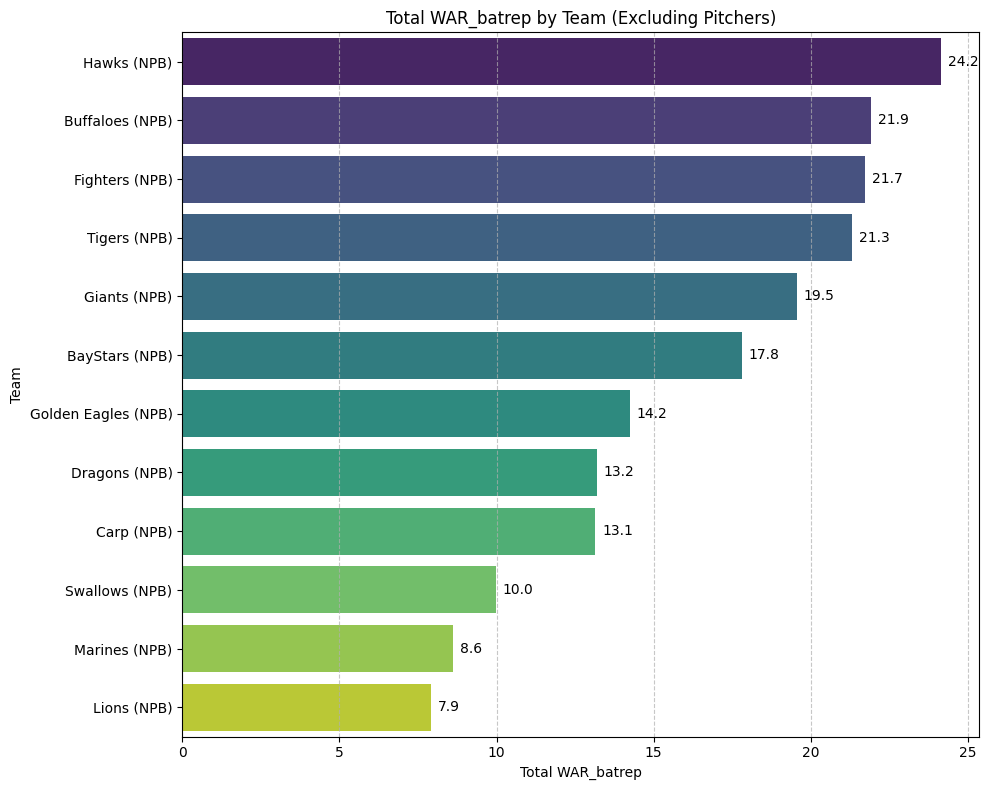

In [54]:
# おまけ：チーム別WAR_batrepの集計（投手除く）

# Positionが'P'ではないレコードをフィルタリング
df_non_pitchers = df_batrep_2025[df_batrep_2025['Position'] != 'P']

# Team別にWAR_batrepを集計
team_war_batrep = df_non_pitchers.groupby('Team')['WAR_batrep'].sum().sort_values(ascending=False).reset_index()

# 横棒グラフの作成
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='WAR_batrep', y='Team', data=team_war_batrep, hue='Team', palette='viridis', legend=False)
plt.title('Total WAR_batrep by Team (Excluding Pitchers)')
plt.xlabel('Total WAR_batrep')
plt.ylabel('Team')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# データラベルを追加
for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha = 'left', va = 'center',
                xytext = (5, 0),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()